In [1]:
import pandas as pd 
import json 
import os
import random
from tqdm import tqdm 
import pickle 
from collections import defaultdict
from collections import Counter
from functions import *
import numpy as np
import scipy.sparse as sp
import matplotlib.pyplot as plt 
from collections import Counter


Bad key "text.kerning_factor" on line 4 in
/Users/domenicospoto/opt/anaconda3/envs/algotrading/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


In [3]:
"""
Renaming the columns dataset
"""
df = pd.read_csv("wikigraph_reduced.csv", sep='\t') 
df.columns = ["Edges",'Source', 'Target']

In [5]:
df.head(5)

,Edges,Source,Target
0,796,95,1185516
1,909,108,1059989
2,910,108,1062426
3,911,108,1161925
4,1141,134,541222


In [4]:
"""
save renamed dataset into a csv file
"""
df.to_csv('data/dataset.csv', index=False)

In [6]:
"""
Taking as input the file wiki-topcats-page-names.txt, return a Dictionary with key the number of 
the page and as value the name of the page. 
"""
# keys: number of the page (article)
# values: name of the page (article)
p = open("wiki-topcats-page-names.txt", "r")
pages = {}
for pag in tqdm(p): 
    list_ = pag.split()[1:]
    aux = ' '.join(list_)
    pages[int(pag.split()[0])] = aux


1791489it [00:04, 434584.70it/s]


In [7]:
write_pickle('data/pages.pkl', pages)

In [3]:
pages = read_pickle('data/pages.pkl')

In [85]:
"""
Return the dictionary where as key the name of the category and 
as value the number of the articles that appears in the category. 
"""
# keys: category
# values: [list of the number of the pages (article)]
cat = open("wiki-topcats-categories.txt", "r")
categories = {}
for i in tqdm(cat): 
    category = i.split()[0][9:-1]
    page_in_cat = list(map(int, i.split()[1:])) 
    categories[category] = page_in_cat


17364it [00:01, 14302.11it/s]


In [11]:
write_pickle('data/categories.pkl', categories)

In [8]:
categories = read_pickle('data/categories.pkl')

In [88]:
"""
each pages has a list of the names of the categories wich are linked to
"""
# keys: number of the page (article)
# values: [list of categories]
cat = open("wiki-topcats-categories.txt", "r")
cat_per_pages = {}
for i in tqdm(cat):
    category = i.split()[0][9:-1]
    page_in_cat = list(map(int, i.split()[1:]))

    if len(page_in_cat) >5000 and len(page_in_cat) < 30000:
        for x in page_in_cat:
            if x not in cat_per_pages:
                a= []
                a.append(category)
                cat_per_pages[x]=a
            else: 
                aux = list(cat_per_pages[x])
                aux.append(category)
                cat_per_pages[x]= aux

17364it [00:07, 2228.83it/s]


In [89]:
"""
reducing cat_per_pages dictionary 
to have the condition that only one page is linked to only one category. 

"""
# keys: number of the page (article)
# values: category chosen at random and referring to that page
one_cat_per_pages = {}
for key, elem in tqdm(cat_per_pages.items()):
    one_cat_per_pages[key] = random.choices(elem, k = 1)


100%|██████████| 149794/149794 [00:00<00:00, 604531.93it/s]


In [90]:
write_pickle('data/one_cat_per_pages.pkl', one_cat_per_pages)

In [91]:
one_cat_per_pages = read_pickle('data/one_cat_per_pages.pkl')

In [92]:
"""
Finally, we create a last dictionary that takes us back to the initial state, i.e. 
the name of the category and the pages (integers) in that category. 
This time, each page is linked to a single category.
"""
# keys: category chosen at random 
# values: number of the pages (article) referring to the category
categories_red = {}
for key, elem in tqdm(one_cat_per_pages.items()):

    if elem[0] not in categories_red:
            a= []
            a.append(key)
            categories_red[elem[0]]=a
    else: 
            aux = list(categories_red[elem[0]])
            aux.append(key)
            categories_red[elem[0]]= aux


100%|██████████| 149794/149794 [00:02<00:00, 61224.65it/s]


In [93]:
write_pickle('data/categories_red.pkl', categories_red)

In [94]:
categories_red = read_pickle('data/categories_red.pkl')

# RQ1

In [16]:
data = pd.read_csv('data/dataset.csv')

Creation of the Graph

In [ ]:
graph = get_graph_dictionary(data)

In [8]:
write_pickle('data/graph.pkl', graph)

In [17]:
graph = read_pickle('data/graph.pkl')

In [18]:
g = Graph(graph)

### Is the graph directed?

In [ ]:
"""
TO DO: review- Kernel Stopped 
Initialize the Graph
"""
import networkx as nx
import scipy as sp

a = (g.edges())
G = nx.DiGraph()
G.add_nodes_from(g.edges())
nx.is_directed()

In [ ]:
A = nx.to_scipy_sparse_matrix(G)

In [8]:
def IsSymmetric(mat):
    """
    Build a lil matrix to create a sparse matrix of the vertices and edges,
    get the sum of the point in the matrix,
    check if the matrix is symmetric or not
    """
    mat = sp.lil_matrix((max(g.vertices())+1,max(g.vertices())+1), dtype=int)
    # looping on each vertex to assign the edges == 1
    for vertex in g.graph_d:   
        for target in g.graph_d[vertex]:
            mat[vertex, target] = 1
    
    rows, cols = mat.nonzero() # get only the non zero elements from the sparse matrix 
    return rows, cols

In [64]:
# method to check if the matrix is symmetric
rows, cols = IsSymmetric(mat)
if np.cumsum((mat[cols, rows] == mat[rows, cols]).A)[-1] == mat[cols, rows].shape[1]:
    print('Is symmetric')
else:
    print('No symmetric')

/Users/domenicospoto/opt/anaconda3/envs/algotrading/lib/python3.7/site-packages/ipykernel_launcher.py:3: SparseEfficiencyWarning: Comparing sparse matrices using == is inefficient, try using != instead.
  This is separate from the ipykernel package so we can avoid doing imports until


Is symmetric


### How many articles are we considering?

In [11]:
print("Aricles of the graph:")
print(len(g.vertices()))

Aricles of the graph:
98343


### How many hyperlinks between pages exist?

In [12]:
print("Hyperlinks of the graph:")
print(len(g.edges()))

Hyperlinks of the graph:
483094


### Compute the average number of links in an arbitrary page. What is the graph density? Do you believe that the graph is dense or sparse? Is the graph dense?

In [38]:
"""
prendo 100 pagine e calcolo la media del numero di link per pagina
"""
list_ = []
for i in range(100):
    list_.append(average_number_pages1(g))
    avg = sum(list_)/len(list_)
print(avg)

5.53


Here we compute the density of the graph. 
Since our graph is directed, we can compute the density as follows:
    $$D = \frac{\lvert{E}\rvert}{2\binom{\lvert{V}\rvert}{2}} = \frac{\lvert{E}\rvert}{\lvert{V}\rvert(\lvert{V}\rvert - 1)}$$

In [13]:
density_graph(g)

4.9951571365597335e-05

From the results, we may say that our graph is sparse because the density is close to 0.

### Visualize the nodes' degree distribution

#### In degree Distribution 

In [22]:
concat = [data['Source'], data['Target']]
df_concat = pd.concat(concat)

In [23]:
all_nodes = list(df_concat.unique())
d_aux = dict.fromkeys(all_nodes, 0)
only_target_node = list(data.Target)
for node in tqdm(only_target_node):
    d_aux[node] +=1

100%|██████████| 483094/483094 [00:00<00:00, 1480484.64it/s]


In [24]:
in_deg = Counter(sorted(list(d_aux.values())))
y_in = np.array(list(in_deg.values()))
y_in = y_in/len(g.vertices())
x_in = list(in_deg.keys())

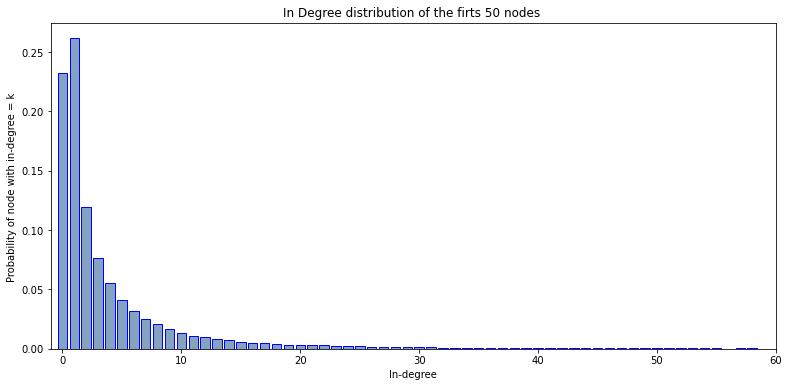

In [44]:
plt.figure(figsize=(13,6))
plt.bar(x_in , y_in,
        color=(0.2, 0.4, 0.6, 0.6),
        edgecolor='blue')
plt.title("In Degree distribution of the firts 50 nodes ")
plt.xlabel("In-degree")
plt.ylabel("Probability of node with in-degree = k ")
plt.xlim(-1, 60)
plt.show()

#### Out-Degree

In [45]:
out_deg_list = []
for key,items in tqdm(g.graph_d.items()):
    if isinstance(g.graph_d[key], list):
         out_deg_list.append(len(g.graph_d[key]))
    elif (isinstance(g.graph_d[key], int)): 
        out_deg_list.append(1) 
out_deg = Counter(sorted(out_deg_list))
x_out = list(out_deg.keys())
y_out =  np.array(list(out_deg.values()))/ len(g.vertices())

100%|██████████| 98343/98343 [00:00<00:00, 708258.32it/s]


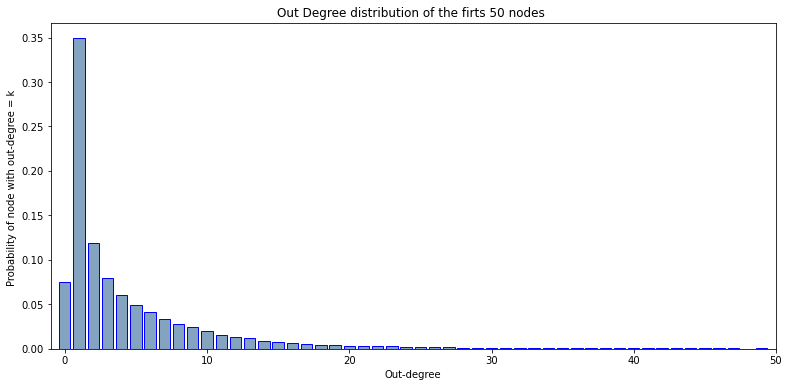

In [46]:
"""
ho troncato la distribuzione a 50 perchè andava troppo oltre e i valori erano tutti 0. 
"""
plt.figure(figsize=(13,6))
plt.bar(x_out, y_out,
        color=(0.2, 0.4, 0.6, 0.6),
        edgecolor='blue')
plt.title("Out Degree distribution of the firts 50 nodes ")
plt.xlabel("Out-degree")
plt.ylabel("Probability of node with out-degree = k ")
plt.xlim(-1, 50)
plt.show()

# RQ2

In [85]:
from collections import defaultdict

dic = defaultdict(list)  # Creating default dictionary to store Source as key and Value as Target
for key,value in zip(data['Source'],data['Target']): 
    dic[str(key)].append(str(value))
    

In [86]:
def pages(page, click):
    total_pages = [] # This list will store number of pages
    page_list = [] #This list will store input vlaue initially and then will add correspondence value as per number of click
    page_list.append(str(page))
    for no_of_click in range(click): #This will run as per number of clicks
        new_lst = []                 
        for i in page_list:
            for j in dic[i]:
                new_lst.append(str(j))
                total_pages.append(str(j))
        page_list = new_lst
    return total_pages

In [87]:
try:
    page = input(" Enter page number ")
    click = input(" Enter number of clicks ")
    if page!='' or click!='':
        total_pages = pages(page,int(click))
        if len(total_pages)!=0:
            print("User can reach {} pages after {} clicks".format(len(total_pages),click))
        else:
            print("There is no link for this page, Kindly try with another page")
    else:
        print(" *********** Kindly provide valid input  **********")
except ValueError:
    print("No valid input! Please try again ...")

 Enter page number 108
 Enter number of clicks 2
User can reach 44 pages after 2 clicks


# RQ3

Define a function that takes in input:
- A category C
- A set of pages in C, p = {p1, ..., pn}

and returns the minimum number of clicks required to reach all pages in p, starting from the page v, corresponding to the most central article, according to the in-degree centrality, in C.

In [75]:
def minimum_number_clicks(graph, categories_red, data):
    print('Write the category')
    while True:
        category_input = str(input())
        if category_input not in categories_red:
            print(category_input, ' not exist as category, change category')
        else:
            break
    print()
    print("Write the set of pages in the category chosen separated by a ','")
    print()
    pages_input = input()
    pages_input = pages_input.split(',')
    pages_input = [int(i) for i in pages_input]

    pages_not = []
    for pages in pages_input:
        if pages not in categories_red[category_input]:
            print(pages, ' not in ', category_input)
            pages_not.append(pages)
    pages_input = [i for i in pages_input if i not in pages_not]  
    
    graph = g.graph_d                    # the graph
    central_vertex = most_central_article(categories_red[category_input], in_degree_centrality(data))[0]   # set the max vertex
    v = central_vertex
    visited = [False] * (max(graph) + 1) # set as False the visited vertex
    queue = []                           # set the queue list
    queue.append(v)                      # append the starting vertex to the list
    queue_complete = []                  # set the complete list to 0 
    visited[v] = True                    # set the starting vertex as visited
    reached = 0                          # initialize the number of reached vertex
    reached_vertex = []                  # initialize the list of reached vertex
    number_of_click = 0

    while queue:
        if reached < (len(pages_input)):
            v = queue.pop(0)
            #print(v, end=' ')

            try:
                number_of_click += 1
                for i in graph[v]:
                    if visited[i] == False:
                        visited[i] = True
                        queue.append(i)
                        queue_complete.append(i)
                        if i in pages_input:
                            reached += 1
                            reached_vertex.append(i)
                            #print('Vertex', i, 'reached')
            except TypeError:
                number_of_click += 1
                j = graph[v]
                if visited[j] == False:
                    visited[j] = True
                    queue.append(j)
                    queue_complete.append(j)
                    if j in pages_input:
                        reached += 1
                        reached_vertex.append(j)
                        #print('Vertex', i, 'reached')

        else:
            break
    print('Reached vertex are: {}'.format(reached_vertex))
    print('Minimum number of clicks, from most central article {} to reach the set of pages, is {}.'.format(central_vertex, number_of_click))
    not_reached_vertex = [i for i in pages_input if i not in reached_vertex]
    print('Not possible to reach {}'.format(not_reached_vertex))

In [78]:
minimum_number_clicks(g.graph_d, categories_red, data)

Write the category
485204
485204  not exist as category, change category
Living_people

Write the set of pages in the category chosen separated by a ','

485204
Reached vertex are: [485204]
Minimum number of clicks, from most central article 1061902 to reach the set of pages, is 39957.
Not possible to reach []


In [63]:
count=0
for el in categories_red['Living_people']:
    if el in q:
        print(el)
    count+=1
    if count == 10000:
        print()
        print('-'*20, count, '-'*20)
        print()
print(count)

485204
1701583
1061024
1161093
324779
632964
1163849
1061974
1162493
1061865
1165354
750547
1163226
27386
77810
76811
27765
27207
322606
383089
83020
538990
539075
540875
1236218
1623309
1502362
86387
538053
538718
1298443
1060506
1503756
66828
1179786
728123
1062186
1403093
1264389
1377369
14816
1415877
67125
538511
1055321
632831
1163323
1224638
1084075
1155762
1161327
1169494
1062792
1170300
1366137
1162025
1578165
1722590
79405
76909
80394
77890
86395
80791
74631
77908
80993
81248
81614
82792
83081
83297
86040
86338
1004498
79222
79253
79978
80575
81217
83053
83784
84346
86035
80413
81577
83815
77089
80543
82523
77930
81008
79281
80125
80820
79334
75078
78694
79259
488423
541031
75228
77018
77088
78345
78368
78766
79061
79182
79599
81336
82662
82933
83222
83308
85674
139158
396855
501116
1005831
79899
80968
81398
78527
78671
78520
79571
80480
82696
83211
83441
84282
84938
1702743
81337
76471
79846
80246
77231
80504
85099
85477
81097
79768
80174
82509
83680
83830
84041
84088
84513
8

552646
558886
559738
561233
561276
561462
561470
561586
571115
571135
571147
573261
580903
580988
581837
582842
584085
585315
586458
587339
587685
588594
589002
589550
590152
592575
593208
594988
598316
601778
601827
601947
601951
601995
602008
602061
602097
602126
602148
602365
604623
604672
604696
604698
605049
611355
611958
612400
626830
626831
626836
626848
626854
626879
626949
626977
627013
627091
627117
627123
627125
627126
627157
627170
627173
627176
627409
627597
628189
630492
631101
631353
631529
631552
631691
631737
632526
632631
632674
632715
632722
632784
632839
632907
632919
632920
633092
633206
633214
633362
633530
633552
633584
633610
633727
633775
633780
633783
633787
633793
633827
633987
634033
634036
634041
634054
634055
634057
634063
634212
634224
634241
634274
635843
636012
636016
639031
639480
639774
639777
639778
639781
639817
639819
650615
654751
655142
655228
655278
655377
655970
656027
656093
658515
658679
659699
659720
659743
659751
659774
659783
659790
659796

1166940
1166949
1166968
1166994
1167221
1167222
1167229
1167233
1167234
1167235
1167244
1167276
1167281
1167297
1167303
1169025
1169171
1169188
1169201
1169271
1169304
1169309
1169312
1169335
1169347
1169348
1169360
1169370
1169372
1169384
1169388
1169469
1169491
1169521
1169555
1169568
1169577
1169586
1169634
1169667
1169698
1169739
1169761
1169762
1169764
1169771
1169775
1169778
1169788
1169805
1169813
1170044
1170045
1170050
1170080
1170113
1170130
1170153
1170155
1170266
1170284
1170301
1170309
1170312
1170335
1170339
1173035
1173154
1174796
1175304
1177107
1177241
1178090
1180027
1181346
1183791
1184005
1184236
1184826
1185775
1186195
1186535
1187522
1188359
1190852
1190872
1190994
1190999
1191576
1192701
1193997
1193999
1194003
1195983
1197894
1197939
1198148
1198781
1199041
1199655
1199671
1199674
1199708
1199720
1200775
1201162
1204293
1208485
1209083
1209084
1209277
1210407
1211635
1215464
1215639
1216079
1216924
1217534
1217538
1218700
1218704
1218706
1218708
1218725
1219650


# RQ4

Given in input two categories: C1 and C2, we get the subgraph induced by all the articles in the two categories.
* take all articles in the categories
* take the edges between them?
* only select part of graph that contains them -> graph as input?

now that we have the graph, select what's needed from it

In [ ]:
sub_graph = cat_subgraph('Main_Belt_asteroids', 'Asteroids_named_for_people', ds)
sub_graph

add this in function above

In [ ]:
for key,val in sub_graph.items():
    if isinstance(sub_graph[key], int):
        sub_graph[key] = [sub_graph[key]]

In [ ]:
sub_g = Graph(sub_graph)

In [ ]:
G = nx.Graph()
G.add_edges_from(sub_g.edges())
show_first_order_neigbors(G, start_node=865446)

#### second function

Let v and u two arbitrary pages in the subgraph. What is the minimum set of hyperlinks one can remove to disconnect u and v?

In [ ]:
find_hyperlinks(sub_graph, 865445, 865449)

In [ ]:
min_hyperlinks(sub_graph, 865445, 865449)

# RQ5

In [ ]:
concat = [ds['Source'], ds['Target']]
df_concat = pd.concat(concat)
all_nodes = list(df_concat.unique())

In [104]:
def relevant_pages(c, df):
    a = cat[c]
    
    d1 = df[df['Source'].isin(a)]
    d2 = df[df['Target'].isin(a)]
    
    concat = [d1['Source'], d2['Target']]
    df_concat = pd.concat(concat)
    d = list(df_concat.unique())
    
    return d

In [105]:
def page_distance(start, category, df, sub_graph, visited, distance):
    queue = [] + [start]
    order = 0
    visited[start] = True 
    distance[start] = order
    l = relevant_pages(category, df)
    distances = []
    
    while len(queue) > 0 :
        order += 1     
        z = queue[0]
        queue.pop(0)
        
        for i in sub_graph[z]:
            if i in l:
                if visited[i] == False:
                    queue.append(i)
                    visited[i] = True
                if distance[i] > distance[z]:
                    distance [i] = distance[z] + 1
                    distances.append(distance[i])

    return distances

this needs to be converted into another function, that finds the median

In [107]:
def distances_from_category(ic, cat, all_nodes):
    results = {}

    for c in tqdm(cat.keys()):
        if c != ic:
            visited = dict.fromkeys(all_nodes, False)
            distance = dict.fromkeys(all_nodes, float('inf'))
            sub_graph = cat_subgraph(c, ic, ds)
            for key,val in sub_graph.items():
                if isinstance(sub_graph[key], int):
                    sub_graph[key] = [sub_graph[key]]
            pages = relevant_pages(c, ds)
            aux = []
            for i in pages:
                x = page_distance(i, ic, ds, sub_graph, visited, distance)
                if x:
                    aux.append(x)
            merged = np.array(list(itertools.chain(*aux)))
            m = np.median(merged)
            results[c] = m
            
    write_pickle('data/' + ic, results)
    return (results)

# RQ6

In [19]:
len(categories_red['Buprestoidea'])

543

In [73]:
data[data['Target'] == 1185516].Source.values.tolist()

[95, 1198096, 1230864]

In [78]:
concat = [data['Source'], data['Target']]    # concat all the nodes
all_nodes = list(pd.concat(concat).unique()) 
inbound = {}
for node in all_nodes:
    inbound[node] = data[data['Target'] == node].Source.values.tolist()
#for _,row in data.iterrows():
#    inbound[row['Target']].append(row['Source'])

In [20]:
normalized_vertex = dict.fromkeys(categories_red['Buprestoidea'], 1/len(categories_red['Buprestoidea'])) 

In [22]:
normalized_vertex

{301: 0.001841620626151013,
 302: 0.001841620626151013,
 303: 0.001841620626151013,
 304: 0.001841620626151013,
 305: 0.001841620626151013,
 306: 0.001841620626151013,
 307: 0.001841620626151013,
 308: 0.001841620626151013,
 309: 0.001841620626151013,
 310: 0.001841620626151013,
 311: 0.001841620626151013,
 312: 0.001841620626151013,
 313: 0.001841620626151013,
 314: 0.001841620626151013,
 315: 0.001841620626151013,
 316: 0.001841620626151013,
 317: 0.001841620626151013,
 318: 0.001841620626151013,
 319: 0.001841620626151013,
 320: 0.001841620626151013,
 321: 0.001841620626151013,
 322: 0.001841620626151013,
 323: 0.001841620626151013,
 324: 0.001841620626151013,
 325: 0.001841620626151013,
 326: 0.001841620626151013,
 327: 0.001841620626151013,
 328: 0.001841620626151013,
 329: 0.001841620626151013,
 330: 0.001841620626151013,
 331: 0.001841620626151013,
 332: 0.001841620626151013,
 333: 0.001841620626151013,
 334: 0.001841620626151013,
 335: 0.001841620626151013,
 336: 0.001841620626

In [79]:
inbound

{95: [],
 108: [],
 134: [1061485, 1163610, 1163783, 1165126, 1266493],
 153: [744272, 1064807, 1065282, 1085943, 1162238],
 167: [523896, 804311],
 173: [146870, 1059766, 1063977, 1163227],
 174: [173, 1054354, 1057189, 1061112, 1061313, 1065339, 1197907],
 980: [1067601],
 1086: [1773335],
 1087: [1088, 743828, 1028633, 1062055, 1062794, 1063918, 1161300, 1161782],
 1088: [1087, 1089, 402381, 1067788],
 1089: [402381, 1169678],
 1099: [1054726],
 1100: [1118, 1619976],
 1104: [167390, 819505],
 1106: [1109, 678174, 1060045, 1060182, 1066543],
 1109: [110216, 1054799, 1227911],
 1118: [1100],
 1121: [],
 1122: [150702, 930458, 1054254, 1057398, 1059151, 1065296, 1339436],
 1123: [1057316, 1060969, 1062762, 1062764, 1062834, 1063034, 1064487],
 1124: [30848,
  344345,
  711131,
  711893,
  1055496,
  1057791,
  1059111,
  1060162,
  1064496,
  1064499,
  1065555,
  1067345,
  1755747],
 1125: [711558, 819728, 1055616, 1068389, 1163874, 1198716],
 1131: [1028847, 1061731, 1163271],
 113

In [24]:
max_iterations = 2
for i in max_iterations:
    normalized_vertex_temp = dict.fromkeys(categories_red['Buprestoidea'], 0) 
    for vertex in normalized_vertex:
        pr = 0
        for in_bound in inbound[vertex]:
            pr += normalized_vertex[inbound]/out_degree_centrality(g)[inbound]
        
        normalized_vertex_temp[vertex] = pr
    
    normalized_vertex = normalized_vertex_temp

SyntaxError: unexpected EOF while parsing (<ipython-input-24-708051414f0f>, line 1)

In [49]:
inbound[301]

[]

In [82]:
out_degree_centrality(g)[0]

7423